# Faiss- Introduction

In [1]:
# !pip install faiss
# !pip install sentence-transformers

Faiss is a library — developed by Facebook AI — that enables efficient similarity search.

So, given a set of vectors, we can index them using Faiss — then using another vector (the query vector), we search for the most similar vectors within the index.

Create dataframe from text

In [1]:
import pandas as pd
data = [['Where are your headquarters located?', 'location'],
['Throw my cellphone in the water', 'random'],
['Network Access Control?', 'networking'],
['Address', 'location']]
df = pd.DataFrame(data, columns = ['text', 'category'])

In [5]:
df

,text,category
0,Where are your headquarters located?,location
1,Throw my cellphone in the water,random
2,Network Access Control?,networking
3,Address,location


Create word embeddings

In [2]:
from sentence_transformers import SentenceTransformer
text = df['text']
encoder = SentenceTransformer("paraphrase-mpnet-base-v2")
vectors = encoder.encode(text)
print(vectors)

[[-0.00437629 -0.0638776  -0.11621013 ...  0.09268754 -0.04782981
  -0.0548407 ]
 [-0.01245354 -0.2650541  -0.04051865 ...  0.14551312  0.13894202
   0.10772914]
 [-0.01477687  0.05492483  0.03377837 ...  0.08851669 -0.1465776
  -0.02152424]
 [-0.0039307   0.12958983 -0.03537015 ...  0.03184687 -0.11042553
   0.02578499]]


**IndexFlatL2**

IndexFlatL2 measures the L2 (or Euclidean) distance between all given points between our query vector, and the vectors loaded into the index. It’s simple, very accurate, but not too fast.

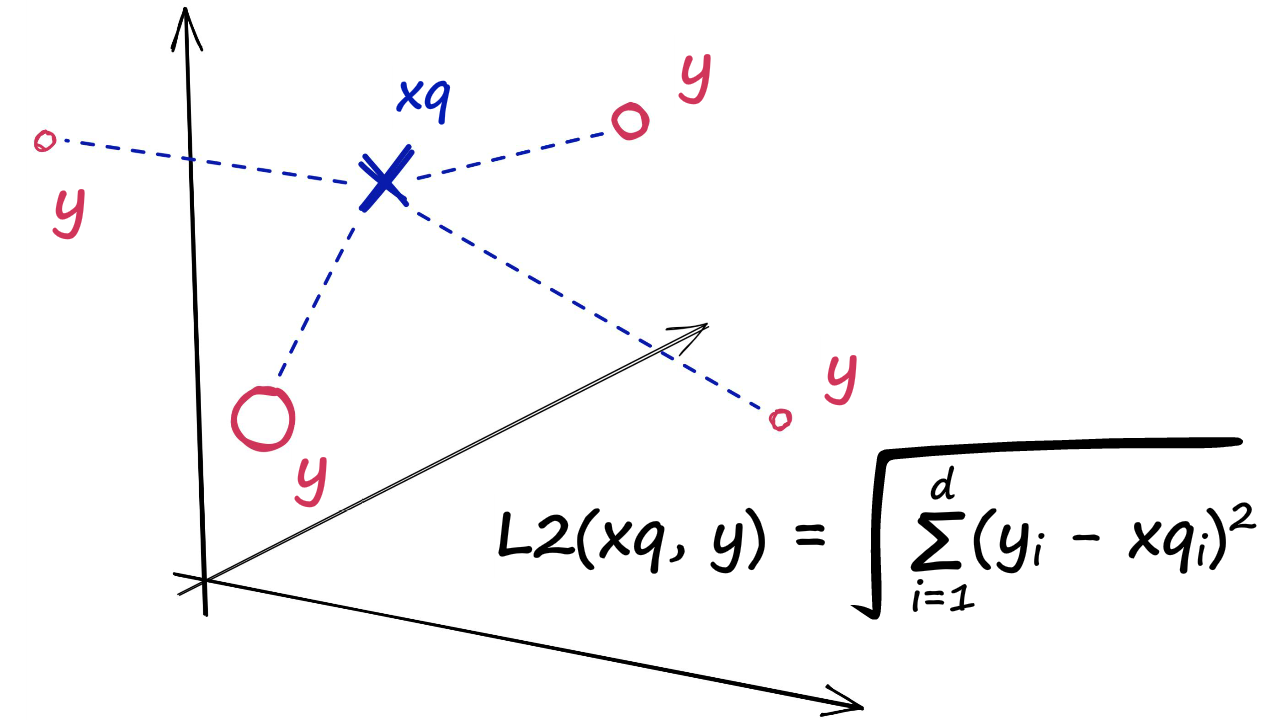

In [50]:
import faiss

vector_dimension = vectors.shape[1]
index = faiss.IndexFlatL2(vector_dimension)
faiss.normalize_L2(vectors)
index.add(vectors)

In [51]:
vector_dimension

768

Create a search vector

In [52]:
import numpy as np

search_text = 'where is your office?'
search_vector = encoder.encode(search_text)
_vector = np.array([search_vector])
faiss.normalize_L2(_vector)

Search

In [53]:
k = index.ntotal
print(k)
distances, ann = index.search(_vector, k=k)
print(distances, ann)

4
[[0.58487236 1.1759498  1.6442652  1.9197671 ]] [[0 3 2 1]]


In [28]:
# we have 4 vectors to return (k) - so we initialize a zero array to hold them
vecs = np.zeros((k, vector_dimension))
# then iterate through each ID from I and add the reconstructed vector to our zero-array
for i, val in enumerate(ann[0].tolist()):
    vecs[i, :] = index.reconstruct(val)

In [31]:
print(vecs.shape)
vecs[0][:100]

(4, 768)


array([-0.00128639, -0.01877655, -0.03415947, -0.01017803,  0.02147161,
       -0.01386229,  0.03670024,  0.00339926,  0.00451996, -0.00778068,
       -0.04917212, -0.040642  , -0.01306256, -0.08269493, -0.00831265,
        0.04093258,  0.01106568,  0.01287356, -0.09287103, -0.02434819,
       -0.04066681, -0.01182641, -0.00732133, -0.01297958, -0.0430893 ,
       -0.0248127 , -0.0240758 ,  0.03003833,  0.03873868,  0.06766866,
        0.07690305, -0.01048145, -0.02526157,  0.01759553,  0.01223737,
        0.01868678,  0.01656547,  0.00463454, -0.03916938,  0.03742806,
        0.0391794 , -0.01020029, -0.04465318, -0.00310818, -0.06519046,
       -0.00909546,  0.03452561, -0.01126784,  0.03266625,  0.03194556,
        0.01067635, -0.03639045, -0.02937272, -0.00682226, -0.06627662,
       -0.00968493, -0.00575243,  0.01110531, -0.01519794, -0.01707326,
        0.01928955, -0.02574632,  0.02167359, -0.00142321, -0.02811068,
        0.02874785,  0.02899323, -0.01160017, -0.01061975, -0.05

**Partitioning the index into voronoi cells**

Using this method, we would take a query vector xq, identify the cell it belongs to, and then use our IndexFlatL2 (or another metric) to search between the query vector and all other vectors belonging to that specific cell.

So, we are reducing the scope of our search, producing an approximate answer, rather than exact (as produced through exhaustive search).

To implement this, we first initialize our index using IndexFlatL2 — but this time, we are using the L2 index as a quantizer step — which we feed into the partitioning IndexIVFFlat index.

In [32]:
nlist = 2  # how many cells
quantizer = faiss.IndexFlatL2(vector_dimension)
index = faiss.IndexIVFFlat(quantizer, vector_dimension, nlist)

index.is_trained

False

In [33]:
index.train(vectors)
index.is_trained  # check if index is now trained

True

In [34]:
index.add(vectors)
index.ntotal  # number of embeddings indexed

4

In [35]:
distances, ann = index.search(_vector, k=k)
print(distances, ann)

[[5.8487236e-01 1.1759498e+00 1.9197671e+00 3.4028235e+38]] [[ 0  3  1 -1]]


We can increase the number of nearby cells to search too with `nprobe`.

In [36]:
index.nprobe = 10

In [37]:
distances, ann = index.search(_vector, k=k)
print(distances, ann)

[[0.58487236 1.1759498  1.6442652  1.9197671 ]] [[0 3 2 1]]


mapping vectors to index

In [38]:
index.make_direct_map()

In [42]:
index.reconstruct(3)[:100]

array([-0.00118611,  0.03910447, -0.01067314, -0.01111854,  0.01867593,
        0.0066881 ,  0.06483159, -0.02649583,  0.02985307,  0.04370825,
       -0.03467142, -0.03963957, -0.03191404,  0.0042938 , -0.0025622 ,
        0.0156048 ,  0.02440043,  0.00167183, -0.06695272,  0.00161391,
       -0.03113438,  0.00200184, -0.02102295, -0.02654137,  0.05660184,
        0.0129169 , -0.02271609,  0.00403487,  0.05587965,  0.00704223,
        0.04472035, -0.01645034,  0.00782201, -0.00183072,  0.0366357 ,
        0.01704964, -0.05015548, -0.00170977, -0.04279662, -0.01098639,
        0.00248191,  0.00351388, -0.03340412, -0.04299549, -0.0197124 ,
       -0.0587404 ,  0.0137715 ,  0.06525724,  0.01098193,  0.06085195,
        0.03441458, -0.01309927,  0.00880155,  0.0040326 , -0.01167803,
       -0.06922244,  0.00651745, -0.01653091, -0.00334105,  0.05675039,
        0.02948605, -0.01200713, -0.01471957, -0.00431041,  0.00206539,
       -0.00113843,  0.03067949,  0.01325365, -0.00817917, -0.04

Product Quantization
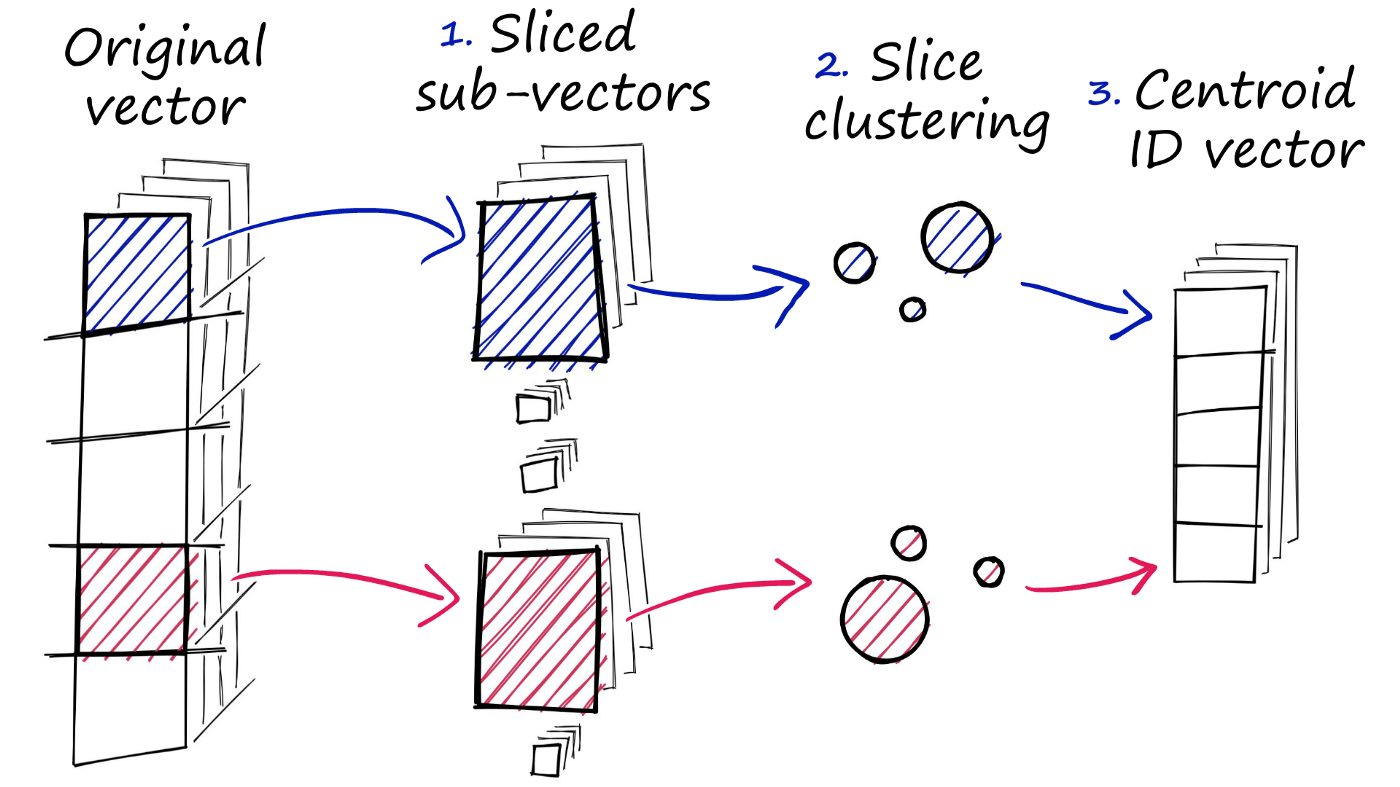

We split the original vector into several subvectors.

For each set of subvectors, we perform a clustering operation — creating multiple centroids for each sub-vector set.

In our vector of sub-vectors, we replace each sub-vector with the ID of it’s nearest set-specific centroid.

In [44]:
m = 2  # number of centroid IDs in final compressed vectors
bits = 2 # number of bits in each centroid

quantizer = faiss.IndexFlatL2(vector_dimension)  # we keep the same L2 distance flat index
index = faiss.IndexIVFPQ(quantizer, vector_dimension, nlist, m, bits) 

In [45]:
index.is_trained

False

In [46]:
index.train(vectors)

In [47]:
index.add(vectors)

In [48]:
index.nprobe = 5

In [49]:
distances, ann = index.search(_vector, k=k)
print(distances, ann)

[[0.58487236 1.1759498  1.6442652  1.919767  ]] [[0 3 2 1]]
